<a href="https://colab.research.google.com/github/Jayasai6280/FMML-LABS/blob/main/FMML_Module4_Lab4_June2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOUNDATIONS OF MODERN MACHINE LEARNING, IIIT Hyderabad
# Module 4
## Lab 4: Support Vector Machines

In [1]:
#Importing the necessary packages
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import pandas
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt


The topic of classifier in today's lab, SVMs make for really good linear separators. Let us look at an example which has linearly separable data:

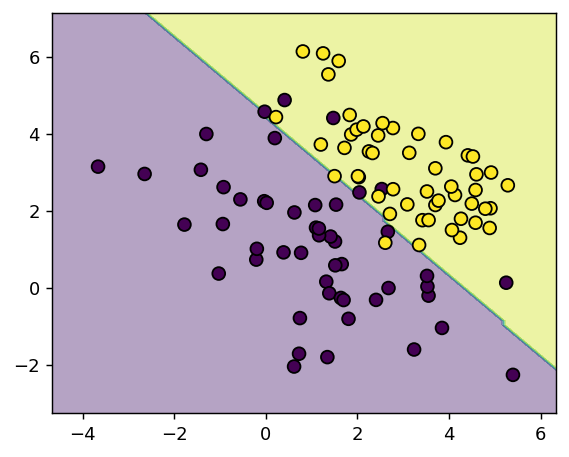

In [2]:
np.random.seed(0)

ar = np.vstack(     [\
                    np.random.multivariate_normal(np.array([1, 1]), 1.5 * np.array([[2, -1], [-1, 2.0]]), size = 50, ),\
                    np.random.multivariate_normal(np.array([3, 3]), 2 * np.array([[0.75, -0.5], [-0.5, 0.75]]), size = 50, )
                    ]\
              )

testAr = np.vstack(   [\
                      np.random.multivariate_normal(np.array([1, 1]), np.array([[0.5, -0.25], [-0.25, 0.5]]), size = 500, ),\
                      np.random.multivariate_normal(np.array([3, 3]), np.array([[0.75, -0.5], [-0.5, 0.75]]), size = 500, )
                      ]\
                  )
testy = np.array([0] * int((testAr.shape[0]/2)) + [1] * int((testAr.shape[0]/2)))

X = ar
y = np.array([0] * int((ar.shape[0]/2)) + [1] * int((ar.shape[0]/2)))

def plotDecisionBoundary(X, y, pair, clf):
  x_min, x_max = X[:, pair[0]].min() - 1, X[:, pair[0]].max() + 1
  y_min, y_max = X[:, pair[1]].min() - 1, X[:, pair[1]].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                      np.arange(y_min, y_max, 0.1))

  y_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  y_pred = y_pred.reshape(xx.shape)
  plt.figure(figsize=(5,4))
  plt.contourf(xx, yy, y_pred, alpha=0.4)
  plt.scatter(X[:, pair[0]], X[:, pair[1]], c = y, s = 50, edgecolor='k')
  # plt.legend()
  plt.gcf().set_dpi(130)
  plt.show()

def boundaryExp() :
  clf = svm.LinearSVC()
  pair = [0, 1]
  clf.fit(X[:, pair], y)
  plotDecisionBoundary(X, y, pair, clf)

  plt.show()

boundaryExp()

## Intuitive introduction to SVMs:

![SVM](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526288453/index3_souoaz.png)

SVMs are an iterative approach of trying to find the optimal hyperplane that divides the multidimentional space into different classes present in the dataset.


**Hyperplanes:** These are the decision planes that separate the objects of classes that we are trying to classify.

**Support Vectors** : Support vectors are the points from dataset that are closest to the hyperplane that divides the dataset.

**Margin**:  The gap between the closest support vectors from the different class along the direction perpendicular to the hyperplane. Simply put, it is the sum of perpendicular distance of the support vector of each class to the hyperplane.

---

Let us try to fall back to the well known dataset and see how SVMs perform on the iris dataset

In [3]:
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
irisData = pandas.DataFrame(\
    data = np.hstack((X,y.reshape(y.shape[0], 1), [[iris["target_names"][int(classIdx)]] for classIdx in y])), \
    columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', "Class", "ClassName"])
irisData.sample(n = 10, random_state = 1)

,sepal_length,sepal_width,petal_length,petal_width,Class,ClassName
14,5.8,4.0,1.2,0.2,0,setosa
98,5.1,2.5,3.0,1.1,1,versicolor
75,6.6,3.0,4.4,1.4,1,versicolor
16,5.4,3.9,1.3,0.4,0,setosa
131,7.9,3.8,6.4,2.0,2,virginica
56,6.3,3.3,4.7,1.6,1,versicolor
141,6.9,3.1,5.1,2.3,2,virginica
44,5.1,3.8,1.9,0.4,0,setosa
29,4.7,3.2,1.6,0.2,0,setosa
120,6.9,3.2,5.7,2.3,2,virginica


Accuracy of the decision tree on the test set: 

0.921


The confusion matrix is : 


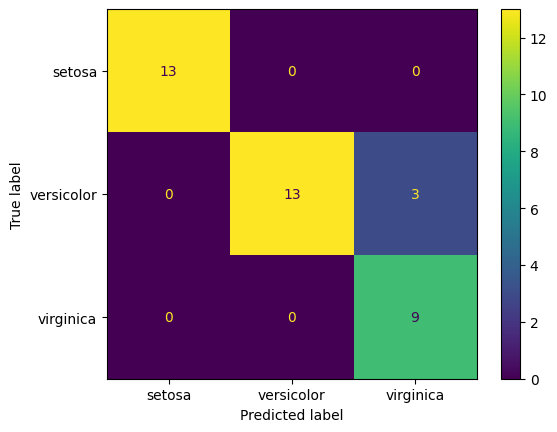

In [4]:
clf = svm.LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy of the decision tree on the test set: \n\n{:.3f}\n\n".format(accuracy_score(y_pred, y_test)))
class_names = iris["target_names"]
print("The confusion matrix is : ")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', values_format='.0f')

plt.show()

Now lets again try to see how does SVM perform when we give it just two of the features from the dataset

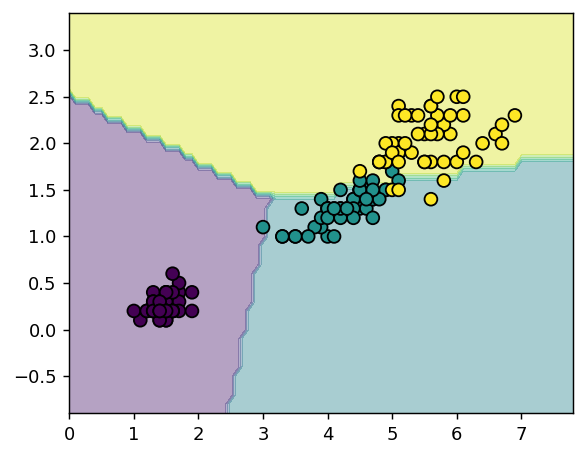

In [5]:
clf = svm.LinearSVC()
pair = [2, 3]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, [2, 3], clf)

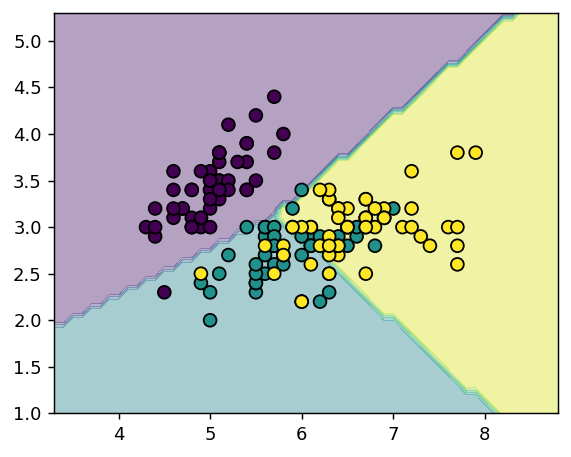

In [6]:
clf = svm.LinearSVC()
pair = [0, 1]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, pair, clf)

#### Alas! We see that SVMs are not able to classify the data in the above experiment because the data is not **linearly separable**

Thankfully, We have a neat trick up our sleeves that will help us to solve these problems. Let us take a look at a typical example that is used to illustrate this trick before we get back to the above dataset.

---

# The Kernel Trick

The true potential of SVMs is unleashed when they are combined with kernels.

## Kernels : An intuitive explanation

Kernel methods are essentially counting on using the training data (say $i^{th}$ example $(x_i, y_i)$ ) itself in a more straightforward way and learning a corresponding weight ($w_i$) for that example. Rather than trying to learn a fixed set of parameters which is done typically.
Depending on the kind of kernel used, we can virtually project the training data in a higher dimension to make it easier for the classifier to classify them.


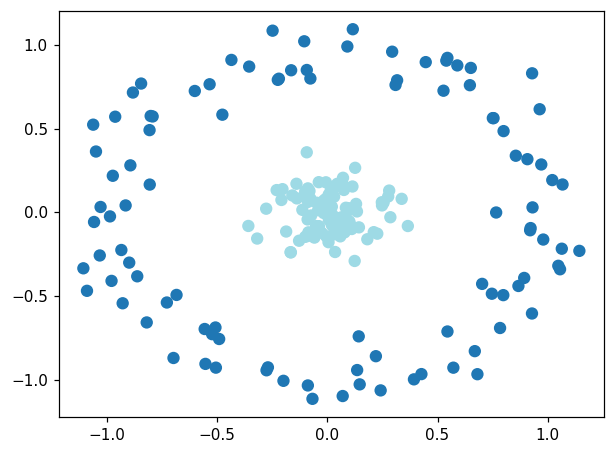

In [7]:
from sklearn.datasets import make_circles
X, y = make_circles(200, factor=.1, noise=.1)

clf = svm.SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='tab20')
plt.gcf().set_dpi(110)

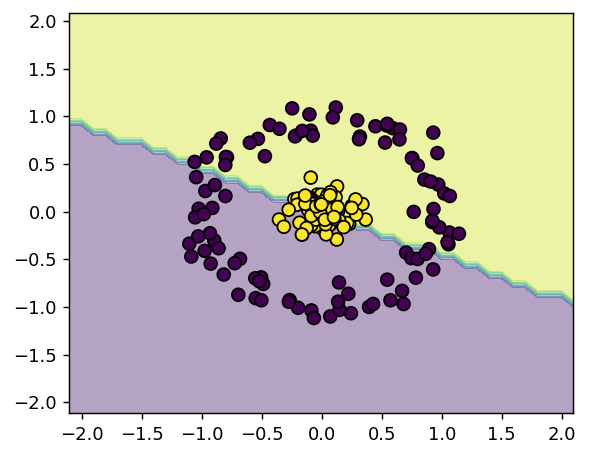

In [8]:
plt.style.use("default")
clf = svm.LinearSVC()
pair = [0, 1]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, [0, 1], clf)

However, if we artificially add another dimention to the dataset of the form:

$z = x^2 + y^2$
we can clearly see a hyperplane that can distinguish both the datasets:

In [9]:
Z = np.array([[i[0]**2 + i[1]**2] for i in X])

In [10]:
X_new = np.hstack((X, Z))

In [11]:
import plotly.graph_objects as go


In [12]:
fig = go.Figure(data = [go.Scatter3d(
    x = X_new[:, 0],
    y = X_new[:, 1],
    z = X_new[:, 2],
    mode = "markers",
    marker = {
        "color" : y,
        "line": {"width" : 4, "color":'DarkSlateGrey'},
        "colorscale": "viridis"},
)])

fig.show()

That simple trick has helped us to get another dimension in which the data is linearly separable by a hyperplane (in this case, a 2d plane)

---

Now let us use the rbf kernel and use an SVM Classifier.

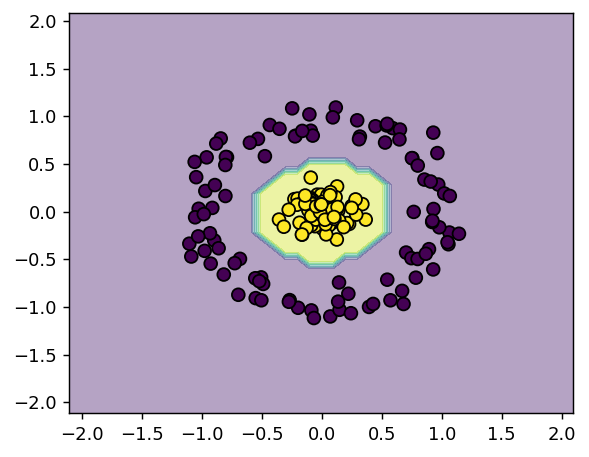

In [13]:
plt.style.use("default")
clf = svm.SVC()
pair = [0, 1]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, [0, 1], clf)

Now let us get back to our original dataset of iris and see if this kernel trick has helped us:

Accuracy of the decision tree on the test set: 

0.974


The confusion matrix is : 


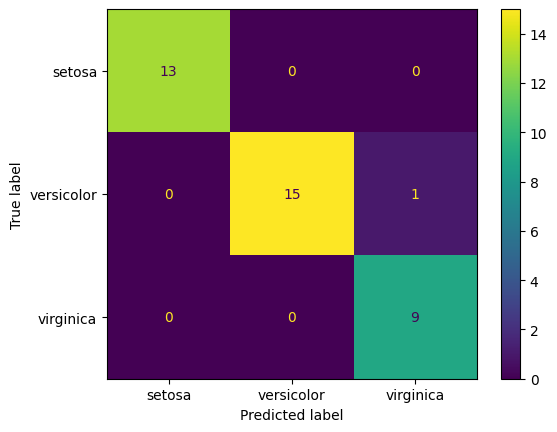

In [14]:
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy of the decision tree on the test set: \n\n{:.3f}\n\n".format(accuracy_score(y_pred, y_test)))
class_names = iris["target_names"]
print("The confusion matrix is : ")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', values_format='.0f')

plt.show()

Certainly, using a kernel has increased our accuracy on the iris dataset.

Things to try out:
- Try to run the same experiment after filtering different features, 2 at a time.
- Using different kinds of kernels for the SVM among: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import rbf_kernel

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Set up the list of feature pairs (indexes of the features)
feature_pairs = [
    [0, 1],  # Sepal Length, Sepal Width
    [0, 2],  # Sepal Length, Petal Length
    [0, 3],  # Sepal Length, Petal Width
    [1, 2],  # Sepal Width, Petal Length
    [1, 3],  # Sepal Width, Petal Width
    [2, 3],  # Petal Length, Petal Width
]

# Set the kernels to test
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

# Loop through each feature pair and each kernel type
for pair in feature_pairs:
    print(f"Training SVM with features: {iris.feature_names[pair[0]]} and {iris.feature_names[pair[1]]}")

    # Select the features based on the pair
    X_selected = X[:, pair]

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, random_state=0)

    # Loop through each kernel type
    for kernel in kernels:
        print(f"\nUsing kernel: {kernel}")

        # If using 'precomputed', compute the kernel matrix
        if kernel == 'precomputed':
            # Use the RBF kernel to compute the kernel matrix
            # You could replace rbf_kernel with other kernel functions like polynomial or linear
            X_train_kernel = rbf_kernel(X_train, X_train)
            X_test_kernel = rbf_kernel(X_test, X_train)  # Test set kernel with training set
        else:
            # For other kernels, use the regular data
            X_train_kernel, X_test_kernel = X_train, X_test

        # Initialize and train the SVM classifier with the chosen kernel
        clf = svm.SVC(kernel=kernel)
        clf.fit(X_train_kernel, y_train)

        # Predict using the test set
        y_pred = clf.predict(X_test_kernel)

        # Print the accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy of the model on the test set: {accuracy:.3f}")

        # Print and display the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:")
        print(cm)

        # Plot the confusion matrix
        class_names = iris["target_names"]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap='viridis', values_format='.0f')

        # Show the confusion matrix plot
        plt.show()

     
Training SVM with features: sepal length (cm) and sepal width (cm)

Using kernel: linear
Accuracy of the model on the test set: 0.763
Confusion Matrix:
[[13  0  0]
 [ 0 11  5]
 [ 0  4  5]]

Using kernel: poly
Accuracy of the model on the test set: 0.763
Confusion Matrix:
[[13  0  0]
 [ 0 12  4]
 [ 0  5  4]]

Using kernel: rbf
Accuracy of the model on the test set: 0.763
Confusion Matrix:
[[13  0  0]
 [ 0 11  5]
 [ 0  4  5]]

Using kernel: sigmoid
Accuracy of the model on the test set: 0.237
Confusion Matrix:
[[ 0  0 13]
 [ 0  0 16]
 [ 0  0  9]]

Using kernel: precomputed
Accuracy of the model on the test set: 0.763
Confusion Matrix:
[[13  0  0]
 [ 0 11  5]
 [ 0  4  5]]

Training SVM with features: sepal length (cm) and petal length (cm)

Using kernel: linear
Accuracy of the model on the test set: 0.947
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  1  8]]

Using kernel: poly
Accuracy of the model on the test set: 0.947
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  1  8]]

Using kernel: rbf
Accuracy of the model on the test set: 0.974
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]

Using kernel: sigmoid
Accuracy of the model on the test set: 0.237
Confusion Matrix:
[[ 0  0 13]
 [ 0  0 16]
 [ 0  0  9]]

Using kernel: precomputed
Accuracy of the model on the test set: 0.947
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  1  8]]

Training SVM with features: sepal length (cm) and petal width (cm)

Using kernel: linear
Accuracy of the model on the test set: 0.947
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  1  8]]

Using kernel: poly
Accuracy of the model on the test set: 0.947
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  1  8]]

Using kernel: rbf
Accuracy of the model on the test set: 0.947
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  1  8]]

Using kernel: sigmoid
Accuracy of the model on the test set: 0.237
Confusion Matrix:
[[ 0  0 13]
 [ 0  0 16]
 [ 0  0  9]]

Using kernel: precomputed
Accuracy of the model on the test set: 0.974
Confusion Matrix:
[[13  0  0]
 [ 0 16  0]
 [ 0  1  8]]

Training SVM with features: sepal width (cm) and petal length (cm)

Using kernel: linear
Accuracy of the model on the test set: 0.947
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  1  8]]

Using kernel: poly
Accuracy of the model on the test set: 0.947
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  1  8]]

Using kernel: rbf
Accuracy of the model on the test set: 0.947
Confusion Matrix:
[[13  0  0]
 [ 0 14  2]
 [ 0  0  9]]

Using kernel: sigmoid
Accuracy of the model on the test set: 0.237
Confusion Matrix:
[[ 0  0 13]
 [ 0  0 16]
 [ 0  0  9]]

Using kernel: precomputed
Accuracy of the model on the test set: 0.947
Confusion Matrix:
[[13  0  0]
 [ 0 14  2]
 [ 0  0  9]]

Training SVM with features: sepal width (cm) and petal width (cm)

Using kernel: linear
Accuracy of the model on the test set: 0.974
Confusion Matrix:
[[13  0  0]
 [ 0 16  0]
 [ 0  1  8]]

Using kernel: poly
Accuracy of the model on the test set: 0.947
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  1  8]]

Using kernel: rbf
Accuracy of the model on the test set: 0.974
Confusion Matrix:
[[13  0  0]
 [ 0 16  0]
 [ 0  1  8]]

Using kernel: sigmoid
Accuracy of the model on the test set: 0.237
Confusion Matrix:
[[ 0  0 13]
 [ 0  0 16]
 [ 0  0  9]]

Using kernel: precomputed
Accuracy of the model on the test set: 0.974
Confusion Matrix:
[[13  0  0]
 [ 0 16  0]
 [ 0  1  8]]

Training SVM with features: petal length (cm) and petal width (cm)

Using kernel: linear
Accuracy of the model on the test set: 0.974
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]

Using kernel: poly
Accuracy of the model on the test set: 0.974
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]

Using kernel: rbf
Accuracy of the model on the test set: 0.974
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]

Using kernel: sigmoid
Accuracy of the model on the test set: 0.105
Confusion Matrix:
[[ 0  0 13]
 [ 0  0 16]
 [ 5  0  4]]

Using kernel: precomputed
Accuracy of the model on the test set: 0.974
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Set up the list of feature pairs (indexes of the features)
feature_pairs = [
    [0, 1],  # Sepal Length, Sepal Width
    [0, 2],  # Sepal Length, Petal Length
    [0, 3],  # Sepal Length, Petal Width
    [1, 2],  # Sepal Width, Petal Length
    [1, 3],  # Sepal Width, Petal Width
    [2, 3],  # Petal Length, Petal Width
]

# Loop through each feature pair and train the model
for pair in feature_pairs:
    print(f"Training SVM with features: {iris.feature_names[pair[0]]} and {iris.feature_names[pair[1]]}")

    # Select the features based on the pair
    X_selected = X[:, pair]

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, random_state=0)

    # Initialize and train the SVM classifier
    clf = svm.SVC()
    clf.fit(X_train, y_train)

    # Predict using the test set
    y_pred = clf.predict(X_test)

    # Print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of the model on the test set: {accuracy:.3f}")

    # Print and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot the confusion matrix
    class_names = iris["target_names"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', values_format='.0f')

    # Show the confusion matrix plot
    plt.show()

     
Training SVM with features: sepal length (cm) and sepal width (cm)
Accuracy of the model on the test set: 0.763
Confusion Matrix:
[[13  0  0]
 [ 0 11  5]
 [ 0  4  5]]

Training SVM with features: sepal length (cm) and petal length (cm)
Accuracy of the model on the test set: 0.974
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]

Training SVM with features: sepal length (cm) and petal width (cm)
Accuracy of the model on the test set: 0.947
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  1  8]]

Training SVM with features: sepal width (cm) and petal length (cm)
Accuracy of the model on the test set: 0.947
Confusion Matrix:
[[13  0  0]
 [ 0 14  2]
 [ 0  0  9]]

Training SVM with features: sepal width (cm) and petal width (cm)
Accuracy of the model on the test set: 0.974
Confusion Matrix:
[[13  0  0]
 [ 0 16  0]
 [ 0  1  8]]

Training SVM with features: petal length (cm) and petal width (cm)
Accuracy of the model on the test set: 0.974
Confusion Matrix:
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]

## **Additional Critical Thinking Questions**

Consider	a	2-class	classification	problem	in	a	2-dimensional	feature	space	x=[x1,	x2]	with	target	variable	y=±1.	The	training	data	comprises	7
samples	as	shown	in	figure (4	black	diamonds	for	the	positive	class	and	3	white	diamonds	for	the	negative	class). The	“maximum	margin	classifier”
(also	called	linear	“hard	margin”	SVM)	is	a	classifier	that	leaves	the	largest	possible	margin	on	either	side	of	the	decision	boundary.	The	samples	lying	on	the	margin	are	called	support	vectors.

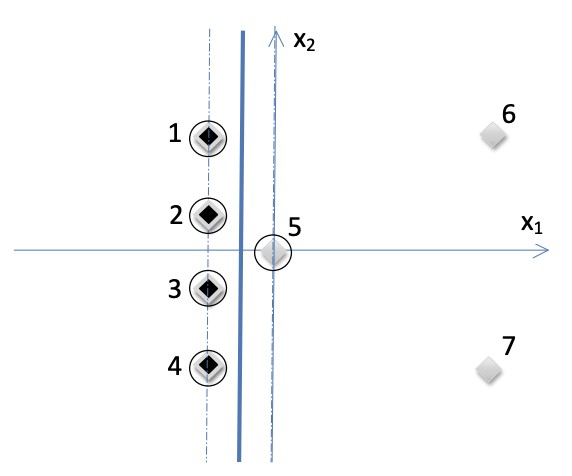


1. Draw	the	decision	boundary	obtained	by	the	linear	hard
margin	SVM	method	with	a	thick	solid	line.	Draw	the	margins	on	either	side with	thinner dashed	lines.	Identify	the	support	vectors.

2. What	is	the	training	error	rate?

3. The	removal	of	which	sample	will	change	the	decision	boundary?

4. What	is	the	leave-one-out	error	rate?


3. The removal of which sample will change the decision boundary?


# After fitting the SVM classifier (e.g., clf.fit(X_train, y_train))
support_vectors = clf.support_  # Get the indices of the support vectors

# Show which samples are support vectors
print("Support Vectors indices:", support_vectors)

# Check the samples that are support vectors
support_vector_samples = X[support_vectors]
print("Support Vector Samples:", support_vector_samples)

     
Support Vectors indices: [3 4 2]
Support Vector Samples: [[4 2]
 [5 4]
 [3 3]]
4. What is the leave-one-out error rate?


from sklearn.model_selection import LeaveOneOut
from sklearn import svm
import numpy as np

# Define the training data (7 samples with 2 features each)
X = np.array([[1, 3], [2, 4], [3, 3], [4, 2], [5, 4], [6, 3], [7, 2]])
y = np.array([1, 1, 1, -1, -1, -1, 1])

# Create the SVM classifier (linear kernel)
clf = svm.SVC(kernel='linear', C=1e5)  # Hard margin, large C ensures no slack variable

# Initialize Leave-One-Out cross-validation
loo = LeaveOneOut()

# List to store predictions and true labels
misclassified = 0
total_samples = 0

# Perform Leave-One-Out Cross-Validation
for train_index, test_index in loo.split(X):
    # Split the data into training and testing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make prediction on the test set
    y_pred = clf.predict(X_test)

    # Check if the prediction is incorrect
    if y_pred != y_test:
        misclassified += 1
    total_samples += 1

# Calculate the Leave-One-Out Error Rate
loo_error_rate = (misclassified / total_samples) * 100

# Output the LOO error rate
print(f"Leave-One-Out Error Rate: {loo_error_rate:.2f}%")

     
Leave-One-Out Error Rate: 57.14%

2. What is the training error rate?


import numpy as np
from sklearn import svm

# Define the training data (7 samples with 2 features each)
X = np.array([[1, 3], [2, 4], [3, 3], [4, 2], [5, 4], [6, 3], [7, 2]])
y = np.array([1, 1, 1, -1, -1, -1, 1])

# Create the SVM classifier (linear kernel)
clf = svm.SVC(kernel='linear', C=1e5)  # Hard margin, large C ensures no slack variable
clf.fit(X, y)

# Predict on the training data
y_pred = clf.predict(X)

# Calculate the number of misclassified samples
misclassified = np.sum(y_pred != y)

# Calculate the training error rate
training_error_rate = (misclassified / len(y)) * 100

# Output the training error rate
print(f"Training Error Rate: {training_error_rate:.2f}%")

     
Training Error Rate: 28.57%

import matplotlib.pyplot as plt
from sklearn import svm

# Define the training data (7 samples with 2 features each)
X = np.array([[1, 3], [2, 4], [3, 3], [4, 2], [5, 4], [6, 3], [7, 2]])
y = np.array([1, 1, 1, -1, -1, -1, 1])

# Create the SVM classifier (linear kernel)
clf = svm.SVC(kernel='linear', C=1e5)  # Hard margin, large C ensures no slack variable
clf.fit(X, y)

# Get the support vectors
support_vectors = clf.support_vectors_

# Get the decision boundary parameters (weights and intercept)
w = clf.coef_[0]
b = clf.intercept_[0]

# Plot the data points
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm', edgecolors='k')

# Plot the support vectors
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], facecolors='none', edgecolors='r', s=100, label='Support Vectors')

# Create the decision boundary and margins
xx = np.linspace(0, 8, 30)
yy = np.linspace(0, 8, 30)
XX, YY = np.meshgrid(xx, yy)
Z = w[0] * XX + w[1] * YY + b
Z = np.sign(Z)

# Plot decision boundary (thick solid line)
plt.contour(XX, YY, Z, levels=[0], linewidths=2, colors='k')

# Plot margins (thinner dashed lines)
Z_margin = w[0] * XX + w[1] * YY + b
plt.contour(XX, YY, Z_margin, levels=[1], linewidths=1, colors='k', linestyles='dashed')
plt.contour(XX, YY, Z_margin, levels=[-1], linewidths=1, colors='k', linestyles='dashed')

# Labels and title
plt.xlabel('
')
plt.ylabel('
')
plt.title('Linear Hard Margin SVM with Decision Boundary and Margins')

plt.legend()
plt.show()


---

Helpful References and sources:

- https://datamites.com/blog/support-vector-machine-algorithm-svm-understanding-kernel-trick/
- https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
- https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
